# Neural Decoding

This demo shows the basics of how to load and understand the data which can be downloaded [here](https://zenodo.org/record/3854034 "O'Doherty 2017")

The paper that describes the data and the movement decoding can be read [here](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95 "Makin 2018")

## Load Data

Data is saved in `.mat` (Matlab) files. Install and include the `mat73` library to allow you to read Matlab v7.3 data files into Python.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import mat73

In [7]:
# load data from a single file into python
fname = "indy_20160407_02.mat"
data = mat73.loadmat(fname)

In [8]:
# extract variables from the data dictionary
for key,val in data.items():
    print(key)
    exec(key + '=val')

chan_names
cursor_pos
finger_pos
spikes
t
target_pos
wf


## Examine the Data

For file `indy_20160407_02.mat`, there are 192 channels, and 204,446 time samples (with Fs=250 samples/sec)

In [9]:
print( f"There are {len(spikes)} electrodes (channels)" )
print( f"There are {len(t):,} time samples")

There are 192 electrodes (channels)
There are 204,446 time samples


Variable `spikes` contains 192 elements, one for each electrode

Each of those elements contains spike times for a single electrode, which in turn may record up to 6 neurons.

For example, `spikes[25][0]` shows there are 3619 timestamps for neuron 0, while `spikes[25][1]` shows 135 spikes for neuron 1.

In [10]:
print( f"Electrode 25, Neuron 0 fires {len(spikes[25][0])} times" )
print( f"Electrode 25, Neuron 1 fires {len(spikes[25][1])} times" )

Electrode 25, Neuron 0 fires 3619 times
Electrode 25, Neuron 1 fires 135 times


The actual spike times are in units of seconds. Therefore `spikes[25][1][0]` shows that the first spike from neuron 1 on electrode 25 happened at $t=62.8$ seconds.

In [11]:
print( "Electrode 25, Neuron 1 fires at t = " + np.array2string(spikes[25][0][0:5] , precision=3) + " seconds")

Electrode 25, Neuron 1 fires at t = [60.076 60.279 60.285 60.354 60.454] seconds


Some neurons are empty. For example `spikes[0][1]` contains `[0,0]` which means it is empty.

We can easily navigate through the data to do things like count how many neurons there are in this data file:

In [12]:
n_neurons = 0
for electrode in spikes:
    for neuron in electrode:
        if len(neuron) > 2: 
            n_neurons += 1
print(f"There are {n_neurons} valid neurons.")

There are 315 valid neurons.


We can make a raster plot to show when each neuron fired. Time is on the x-axis and neurons are on the y-axis:

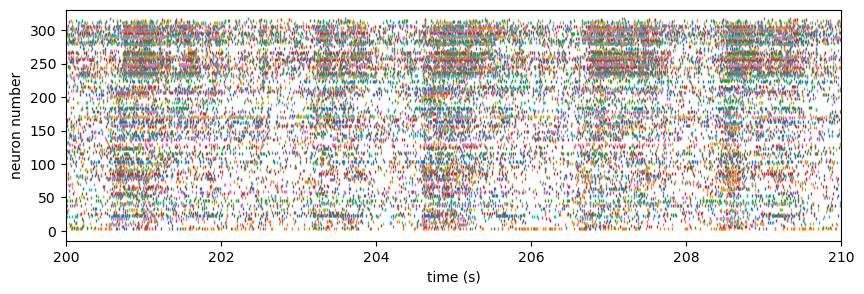

In [13]:
# each dot represents a neuron firing

plt.figure(figsize=(10,3))
vertical_offset = 0

for electrode in spikes:
    for neuron in electrode:
        if len(neuron) > 2: 
            plt.plot(neuron , 
                     np.ones_like(neuron)+vertical_offset ,
                     marker=2 , linestyle='none' , markersize=2
                    )
            vertical_offset += 1


plt.xlim([200,210])
plt.xlabel('time (s)')
plt.ylabel('neuron number')
plt.show()

## Data Binning

The goal is to predict cursor position (x and y) from these firing times. One issue that has to be addressed is time alignment. Cursor positions are recorded every 4ms (250Hz). However firing times are asynchronous, meaning they can occur at any time. This is a problem for us. We need a way to time-align the neuron firing times with the cursor measurement times.

A common solution is to _bin_ the data. This means counting how many times each neuron fires every _bin_ ms. Fortunately, we can use the built-in `np.histogram` function to compute these counts for us:

In [21]:
bin_width = 16e-3   #16ms
bins      = np.arange(0,t[-1],bin_width)
X         = np.zeros((n_neurons,len(bins)-1))

i = 0
for electrode in spikes:
    for neuron in electrode:
        if len(neuron) > 2:
            cnt,_ = np.histogram(neuron,bins)
            X[i,:] = cnt
            i += 1

`X` now holds the binned spike times for the valid neurons. If we want, we can raster plot those counts as well

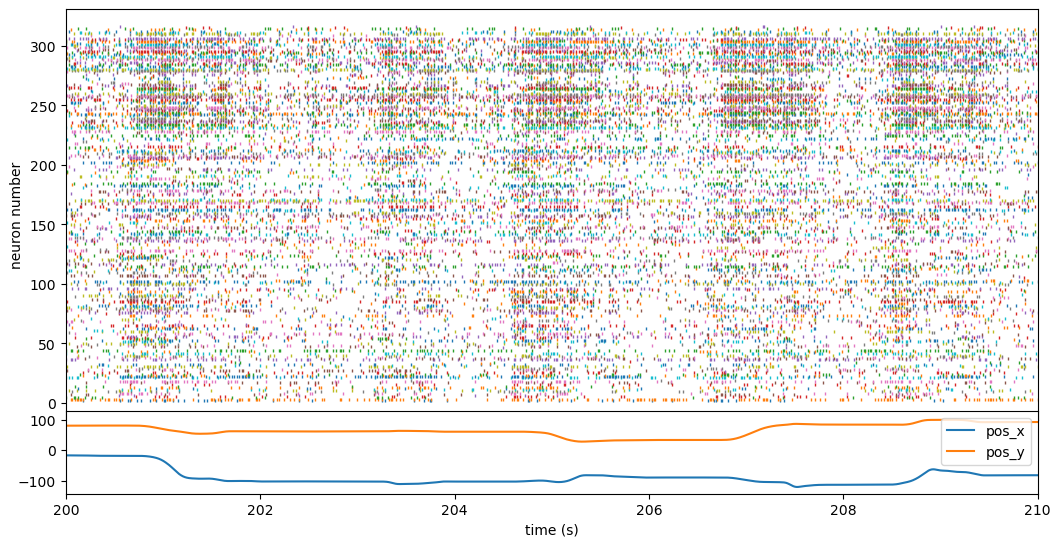

In [68]:
# each dot represents one or more neurons firing per 16 ms bin

bins = np.arange(0,t[-1],bin_width)
bins = bins[0:-1]               # remove the last bin so that cnt len matches bbins len
                                # this is an artifact of how the np.histogram function works

f,ax = plt.subplots(2,1,
                    figsize=(10,5) , 
                    gridspec_kw={'height_ratios': [5, 1]} ,
                    sharex=True)

# create raster plot
vertical_offset = 0
for row in X:
    i = np.where(row>0)[0]
    ax[0].plot(
        bins[i],
        np.ones(len(i)) + vertical_offset , 
        marker=2 , linestyle='none' , markersize=2
    )
    vertical_offset += 1

ax[0].set_ylabel('neuron number')
ax[0].xaxis.set_visible(False)

# create plot of cursor position
ax[1].plot(t,cursor_pos[:,0] , label='pos_x')
ax[1].plot(t,cursor_pos[:,1] , label='pos_y')
ax[1].legend()
ax[1].set_xlabel('time (s)')

# format & show
f.tight_layout(pad=-1)
ax[1].set_xlim([200,210])
plt.show()


This is essentially the same image as the one above but now the spike arrivals are discretized (binned) to a fixed time
resolution of 16ms. I've also added the cursor position traces. You can see that when the hand starts to move (around $t=201$ s) many of the neurons all start to fire at once. There are several such network bursts, and they all seem to occur around when the hand makes a big movement.